 ### NVIDIA AI Enterprise - Predicting Taxi Fares with NVIDIA RAPIDS

The NVIDIA AI Enterprise suite includes the applications, frameworks, and tools used by AI researchers, data scientists, and developers.

<img src="dataset/frameworks.png"/>

The objective of the notebook/lab is to get you familiarized with NVIDIA RAPIDS GPU dataframe library cuDF and how it works with dask and GPU XGBoost. You will be predicting the taxi fare based on the data collected from a plethora of taxi fares. The dataset has columns like pickup points and drop off points timestamps etc. You will use cuDF to ingest data into the GPU and run data cleanup. This information will then be used to train a XGBoost model to predict the Taxi Fares in Manhattan. 

#### Import the RAPIDS libraries and create a Dask worker on the GPU
**We import cudf which is pandas like, cupy which is numpy like and Dask which allow you to scale to multiple GPUs. We also import xgboost for model training later.**  

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import cupy
import numba, socket, time
import cudf
import dask, dask_cudf
import xgboost as xgb
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster

import holoviews as hv
from holoviews import opts
import numpy as np

# connect to the Dask cluster created at Dataproc startup time
# client = Client(socket.gethostname()+':8786')

# if you're not using Dataproc, you can use dask_cuda to create a local CUDA cluster as well
# as shown in the commented code below. Check https://github.com/rapidsai/dask-cuda for help

cluster = LocalCUDACluster()
client = Client(cluster)

# forces workers to restart. useful to ensure GPU memory is clear
# client.restart()

# Inspecting the Data

**Now that we have a GPU worker, we'll use [dask-cudf](https://github.com/rapidsai/dask-cudf/) to load and parse a CSV file into a distributed DataFrame.**

Let's see the first rows of our dataset using the **head** function

In [2]:
df_2014 = dask_cudf.read_csv('dataset/nyc-taxi_csv_2014_yellow_tripdata_2014-01.csv')
df_2014.head().to_pandas()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,CMT,2014-01-09 20:45:25,2014-01-09 20:52:31,1,0.7,-73.994770,40.736828,1,N,-73.982227,40.731790,CRD,6.5,0.5,0.5,1.40,0.0,8.90
1,CMT,2014-01-09 20:46:12,2014-01-09 20:55:12,1,1.4,-73.982392,40.773382,1,N,-73.960449,40.763995,CRD,8.5,0.5,0.5,1.90,0.0,11.40
2,CMT,2014-01-09 20:44:47,2014-01-09 20:59:46,2,2.3,-73.988570,40.739406,1,N,-73.986626,40.765217,CRD,11.5,0.5,0.5,1.50,0.0,14.00
3,CMT,2014-01-09 20:44:57,2014-01-09 20:51:40,1,1.7,-73.960213,40.770464,1,N,-73.979863,40.777050,CRD,7.5,0.5,0.5,1.70,0.0,10.20
4,CMT,2014-01-09 20:47:09,2014-01-09 20:53:32,1,0.9,-73.995371,40.717248,1,N,-73.984367,40.720524,CRD,6.0,0.5,0.5,1.75,0.0,8.75


# Data Cleanup

**As usual, the data needs to be massaged a bit before we can start adding features that are useful to an ML model. For example, in the 2014 taxi CSV files, there are `pickup_datetime` and `dropoff_datetime` columns that we need. Then, we rename a few columns and change the string columns to integers. Integer columns are faster on GPU. Also, some CSV files have column names with extra spaces in them; Let's remove those spaces**

In [3]:
#create a list of columns & dtypes the df must have
must_haves = {
 'pickup_datetime': 'datetime64[ms]',
 'dropoff_datetime': 'datetime64[ms]',
 'passenger_count': 'int32',
 'trip_distance': 'float32',
 'pickup_longitude': 'float32',
 'pickup_latitude': 'float32',
 'rate_code': 'int32',
 'dropoff_longitude': 'float32',
 'dropoff_latitude': 'float32',
 'fare_amount': 'float32'
}

In [5]:
def clean(ddf, must_haves):
    # replace the extraneous spaces in column names and lower the font type
    tmp = {col:col.strip().lower() for col in list(ddf.columns)}
    ddf = ddf.rename(columns=tmp)

    ddf = ddf.rename(columns={
        'tpep_pickup_datetime': 'pickup_datetime',
        'tpep_dropoff_datetime': 'dropoff_datetime',
        'ratecodeid': 'rate_code'
    })
    
    ddf['pickup_datetime'] = ddf['pickup_datetime'].astype('datetime64[ms]')
    ddf['dropoff_datetime'] = ddf['dropoff_datetime'].astype('datetime64[ms]')

    for col in ddf.columns:
        if col not in must_haves:
            ddf = ddf.drop(columns=col)
            continue
        # if column was read as a string, recast as float
        if ddf[col].dtype == 'object':
            ddf[col] = ddf[col].str.fillna('-1')
            ddf[col] = ddf[col].astype('float32')
        else:
            # downcast from 64bit to 32bit types
            # Tesla T4 are faster on 32bit ops
            if 'int' in str(ddf[col].dtype):
                ddf[col] = ddf[col].astype('int32')
            if 'float' in str(ddf[col].dtype):
                ddf[col] = ddf[col].astype('float32')
            ddf[col] = ddf[col].fillna(-1)
    
    return ddf

Use the **map_partitions** function to apply the cleanup to every distributed dataframe.

In [6]:
df_2014 = df_2014.map_partitions(clean, must_haves, meta=must_haves)
taxi_df = df_2014.persist()

## Exploratory Data Analysis (EDA)
**Here, we are checking out if there are any non-sensical records and outliers, for example the pickup time cant be later than the dropoff time and in such case, we need to remove them from the dataset.**

In [7]:
taxi_df[taxi_df.dropoff_datetime <= taxi_df.pickup_datetime].head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
3832,2014-01-09 20:27:41,2014-01-09 19:05:21,1,1.8,0.000000,0.000000,1,-73.969589,40.789001,9.5
16134,2014-01-09 22:15:40,2014-01-09 22:15:14,1,1.3,0.000000,0.000000,1,-74.002861,40.760624,7.5
16181,2014-01-09 22:27:13,2014-01-09 22:26:49,1,1.9,0.000000,0.000000,1,-73.976288,40.741631,8.5
16873,2014-01-10 00:14:23,2014-01-10 00:14:23,1,0.7,-74.005135,40.718693,1,-74.003876,40.728504,4.0
25248,2014-01-10 00:39:16,2014-01-10 00:38:59,1,1.5,0.000000,0.000000,1,-73.999283,40.733898,6.5


**Any data where the trip distance is short but the fare is high is also suspect**

In [8]:
# check out if there is any abnormal data where trip distance is short, but the fare is very high.
taxi_df[(taxi_df.trip_distance < 10) & (taxi_df.fare_amount > 300)].head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
373953,2014-01-12 15:03:38,2014-01-12 15:05:31,1,0.0,-73.823845,40.690258,5,-73.823845,40.690281,400.0
520658,2014-01-06 23:44:07,2014-01-06 23:45:01,1,0.0,-73.927902,41.677242,5,-73.927902,41.677242,370.0
525419,2014-01-06 23:50:28,2014-01-06 23:51:40,1,0.0,-73.927902,41.677242,5,-73.927902,41.677242,370.0
562916,2014-01-07 12:09:38,2014-01-07 12:10:27,1,0.0,-73.929695,40.812031,5,-73.929695,40.812031,500.0
576409,2014-01-07 16:35:10,2014-01-07 16:35:41,1,0.0,-73.996002,40.720932,5,-73.996010,40.720928,500.0


**Conversely, any data where the trip is long but the fare is low is also to be removed**

In [9]:
# check out if there is any abnormal data where trip distance is long, but the fare is very low.
taxi_df[(taxi_df.trip_distance > 50) & (taxi_df.fare_amount < 50)].head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
11580,2014-01-09 22:22:14,2014-01-09 22:42:59,1,82.099998,-74.002174,40.751755,1,-73.964218,40.719555,20.0
33723,2014-01-10 05:43:48,2014-01-10 06:12:20,1,84.199997,-73.965050,40.806671,1,-73.957977,40.713139,34.5
122880,2014-01-10 18:16:53,2014-01-10 18:48:53,1,89.900002,-73.997185,40.742355,1,-73.948364,40.779270,21.5
226264,2014-01-11 13:22:07,2014-01-11 13:40:16,1,81.699997,-73.991684,40.759872,1,-73.994987,40.726055,13.5
290203,2014-01-11 20:12:50,2014-01-11 20:15:15,1,60.400002,-73.968109,40.770878,1,-73.972595,40.764606,4.0


**The plot below visualizes the histogram of fare_amount and we can see some abnormal fare_amount values for some records. Taking this and also the NYC map coordinates into consideration, we will only select records where fare_amount < 500$.**

/opt/conda/envs/rapids/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


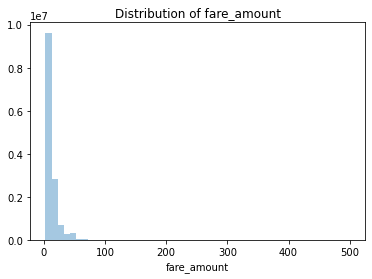

In [10]:
import seaborn as sns
taxi_df_cdf = dask_cudf.read_csv("dataset/nyc-taxi_csv_2014_yellow_tripdata_2014-01.csv").map_partitions(clean,must_haves,meta=must_haves).compute().to_pandas()
sns.distplot(taxi_df_cdf['fare_amount'],kde=False)
plt.title('Distribution of fare_amount')
plt.show()

**Finally, we apply a list of filter conditions to throw out records with missing or outlier values**

In [11]:
query_frags = [
    'fare_amount > 1 and fare_amount < 500',
    'passenger_count > 0 and passenger_count < 6',
    'pickup_longitude > -75 and pickup_longitude < -73',
    'dropoff_longitude > -75 and dropoff_longitude < -73',
    'pickup_latitude > 40 and pickup_latitude < 42',
    'dropoff_latitude > 40 and dropoff_latitude < 42',
    'trip_distance > 0 and trip_distance < 500',
    'not (trip_distance > 50 and fare_amount < 50)',
    'not (trip_distance < 10 and fare_amount > 300)',
    'not dropoff_datetime <= pickup_datetime'
]
taxi_df = taxi_df.query(' and '.join(query_frags))

In [12]:
taxi_df = taxi_df.reset_index(drop=True)
taxi_df.head()

,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount
0,2014-01-09 20:45:25,2014-01-09 20:52:31,1,0.7,-73.994766,40.736828,1,-73.982224,40.731789,6.5
1,2014-01-09 20:46:12,2014-01-09 20:55:12,1,1.4,-73.982391,40.773380,1,-73.960449,40.763996,8.5
2,2014-01-09 20:44:47,2014-01-09 20:59:46,2,2.3,-73.988571,40.739407,1,-73.986626,40.765217,11.5
3,2014-01-09 20:44:57,2014-01-09 20:51:40,1,1.7,-73.960213,40.770466,1,-73.979866,40.777050,7.5
4,2014-01-09 20:47:09,2014-01-09 20:53:32,1,0.9,-73.995369,40.717247,1,-73.984367,40.720524,6.0


# Adding Interesting Features

**Dask & cuDF provide standard DataFrame operations, but also let you run "user defined functions" on the underlying data.**

cuDF's [apply_rows](https://rapidsai.github.io/projects/cudf/en/0.6.0/api.html#cudf.dataframe.DataFrame.apply_rows) operation is similar to Pandas's [DataFrame.apply](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html), except that for cuDF, custom Python code is [JIT compiled by numba](https://numba.pydata.org/numba-doc/dev/cuda/kernels.html) into GPU kernels.

**We'll use a Haversine Distance calculation to find total trip distance, and extract additional useful variables from the datetime fields.**

**Let's also parse the timestamp column to extract month, year, hour and day of the week** 

In [13]:
import math
from math import cos, sin, asin, sqrt, pi

def haversine_distance_kernel(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude, h_distance):
    for i, (x_1, y_1, x_2, y_2) in enumerate(zip(pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude)):
        x_1 = pi/180 * x_1
        y_1 = pi/180 * y_1
        x_2 = pi/180 * x_2
        y_2 = pi/180 * y_2
        
        dlon = y_2 - y_1
        dlat = x_2 - x_1
        a = sin(dlat/2)**2 + cos(x_1) * cos(x_2) * sin(dlon/2)**2
        
        c = 2 * asin(sqrt(a)) 
        r = 6371 # Radius of earth in kilometers
        
        h_distance[i] = c * r

taxi_df = taxi_df.apply_rows(haversine_distance_kernel,
                   incols=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'],
                   outcols=dict(h_distance=np.float32),
                   kwargs=dict())
    

taxi_df['hour'] = taxi_df['pickup_datetime'].dt.hour
taxi_df['year'] = taxi_df['pickup_datetime'].dt.year
taxi_df['month'] = taxi_df['pickup_datetime'].dt.month
taxi_df['day'] = taxi_df['pickup_datetime'].dt.day
taxi_df['day_of_week'] = taxi_df['pickup_datetime'].dt.weekday
taxi_df['is_weekend'] = (taxi_df['day_of_week']>=5).astype('int32')

#calculate the time difference between dropoff and pickup.
taxi_df['diff'] = taxi_df['dropoff_datetime'].astype('int64') - taxi_df['pickup_datetime'].astype('int64')
taxi_df['diff']=(taxi_df['diff']/1000).astype('int64')

taxi_df['pickup_latitude_r'] = taxi_df['pickup_latitude']//.01*.01
taxi_df['pickup_longitude_r'] = taxi_df['pickup_longitude']//.01*.01
taxi_df['dropoff_latitude_r'] = taxi_df['dropoff_latitude']//.01*.01
taxi_df['dropoff_longitude_r'] = taxi_df['dropoff_longitude']//.01*.01

taxi_df = taxi_df.drop('pickup_datetime', axis=1)
taxi_df = taxi_df.drop('dropoff_datetime', axis=1)

In [14]:
taxi_df.head()

,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,fare_amount,h_distance,hour,year,month,day,day_of_week,is_weekend,diff,pickup_latitude_r,pickup_longitude_r,dropoff_latitude_r,dropoff_longitude_r
0,1,0.7,-73.994766,40.736828,1,-73.982224,40.731789,6.5,1.196175,20,2014,1,9,3,0,426,40.730000,-74.000000,40.730000,-73.989998
1,1,1.4,-73.982391,40.773380,1,-73.960449,40.763996,8.5,2.122098,20,2014,1,9,3,0,540,40.770000,-73.989998,40.759998,-73.970001
2,2,2.3,-73.988571,40.739407,1,-73.986626,40.765217,11.5,2.874643,20,2014,1,9,3,0,899,40.730000,-73.989998,40.759998,-73.989998
3,1,1.7,-73.960213,40.770466,1,-73.979866,40.777050,7.5,1.809662,20,2014,1,9,3,0,403,40.770000,-73.970001,40.770000,-73.979996
4,1,0.9,-73.995369,40.717247,1,-73.984367,40.720524,6.0,0.996204,20,2014,1,9,3,0,383,40.709999,-74.000000,40.719997,-73.989998


# Pick a Training Set

Let's imagine you're making a trip to New York on the 25th and want to build a model to predict what fare prices will be like the last few days of the month based on the first part of the month. We'll use a query expression to identify the `day` of the month to use to divide the data into train and test sets.

The wall-time below represents how long it takes your GPU to load data and the ETL portion of the workflow.

In [15]:
%%time
X_train = taxi_df.query('day < 25').persist()

# create a Y_train ddf with just the target variable
Y_train = X_train[['fare_amount']].persist()
# drop the target variable from the training ddf
X_train = X_train[X_train.columns.difference(['fare_amount'])]

# this wont return until all data is in GPU memory
done = wait([X_train, Y_train])

CPU times: user 187 ms, sys: 561 µs, total: 188 ms
Wall time: 816 ms


In [16]:
len(X_train)

9805369

# Train the XGBoost Regression Model

**The wall time output below indicates how long it took your GPU to train an XGBoost model over the training set. While the training is executing, you can click on the tab to the right to view the utilization of GPU compute engines as well as and GPU memory.**

[0]	train-rmse:10.58610
[1]	train-rmse:7.48841
[2]	train-rmse:5.34318
[3]	train-rmse:3.87223
[4]	train-rmse:2.88379
[5]	train-rmse:2.23737
[6]	train-rmse:1.83043
[7]	train-rmse:1.58522
[8]	train-rmse:1.44693
[9]	train-rmse:1.36180
[10]	train-rmse:1.31277
[11]	train-rmse:1.28638
[12]	train-rmse:1.26988
[13]	train-rmse:1.24992
[14]	train-rmse:1.24118
[15]	train-rmse:1.23059
[16]	train-rmse:1.22281
[17]	train-rmse:1.21675
[18]	train-rmse:1.21197
[19]	train-rmse:1.20929
[20]	train-rmse:1.20604
[21]	train-rmse:1.19621
[22]	train-rmse:1.18732
[23]	train-rmse:1.18442
[24]	train-rmse:1.18210
[25]	train-rmse:1.17874
[26]	train-rmse:1.17408
[27]	train-rmse:1.17045
[28]	train-rmse:1.16764
[29]	train-rmse:1.16534
[30]	train-rmse:1.15876
[31]	train-rmse:1.15261
[32]	train-rmse:1.14349
[33]	train-rmse:1.14066
[34]	train-rmse:1.13740
[35]	train-rmse:1.13488
[36]	train-rmse:1.12803
[37]	train-rmse:1.12301
[38]	train-rmse:1.12045
[39]	train-rmse:1.11678
[40]	train-rmse:1.11475
[41]	train-rmse:1.10874
[

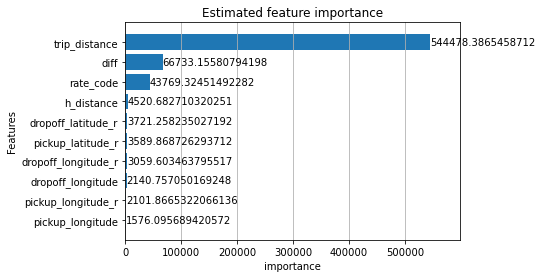

CPU times: user 620 ms, sys: 69.3 ms, total: 689 ms
Wall time: 7 s


In [17]:
%%time

dtrain = xgb.dask.DaskDMatrix(client, X_train, Y_train)

trained_model = xgb.dask.train(client,
                        {
                         'learning_rate': 0.3,
                          'max_depth': 8,
                          'objective': 'reg:squarederror',
                          'subsample': 0.6,
                          'gamma': 1,
                          'silent': True,
                          'verbose_eval': True,
                          'tree_method':'gpu_hist'
                        },
                        dtrain,
                        num_boost_round=100, evals=[(dtrain, 'train')])


ax = xgb.plot_importance(trained_model['booster'], height=0.8, max_num_features=10, importance_type="gain")
ax.grid(False, axis="y")
ax.set_title('Estimated feature importance')
ax.set_xlabel('importance')
plt.show()

# How Good is Our Model?

Now that we have a trained model, we need to test it with the 25% of records we held out.

Based on the filtering conditions applied to this dataset, many of the DataFrame partitions will wind up having 0 rows.

This is a problem for XGBoost which doesn't know what to do with 0 length arrays. We'll apply a bit of Dask logic to check for and drop partitions without any rows.

In [18]:
def drop_empty_partitions(df):
    lengths = df.map_partitions(len).compute()
    nonempty = [length > 0 for length in lengths]
    return df.partitions[nonempty]

In [19]:
X_test = taxi_df.query('day >= 25').persist()
X_test = drop_empty_partitions(X_test)

# Create Y_test with just the fare amount
Y_test = X_test[['fare_amount']]

# Drop the fare amount from X_test
X_test = X_test[X_test.columns.difference(['fare_amount'])]

# display test set size
len(X_test)

3179424

In [20]:
# generate predictions on the test set
'''feed X_test as a dask.dataframe'''

booster = trained_model["booster"] # "Booster" is the trained model
history = trained_model['history'] # "History" is a dictionary containing evaluation results 

booster.set_param({'predictor': 'gpu_predictor'})

prediction = xgb.dask.predict(client, booster, X_test).persist()

wait(prediction)
prediction.head()

0    12.649530
1     7.682663
2     8.384380
3     8.133873
4    14.479967
Name: 0, dtype: float32

In [21]:
prediction = prediction.map_partitions(lambda part: cudf.Series(part)).reset_index(drop=True)
actual = Y_test['fare_amount'].reset_index(drop=True)

Let's check the first few rows of predicted output and actual data to see how close we are

In [22]:
prediction.head()

0    12.649530
1     7.682663
2     8.384380
3     8.133873
4    14.479967
Name: 0, dtype: float32

In [23]:
actual.head()

0    13.0
1     7.5
2     8.0
3     8.0
4    14.5
Name: fare_amount, dtype: float32

# Compute Root Mean Squared Error

In [24]:
# Calculate RMSE
squared_error = ((prediction-actual)**2)

# compute the actual RMSE over the full test set
cupy.sqrt(squared_error.mean().compute())

array(1.30823106)

Not bad! We can predict a taxi fare to within about $1.5.

If I'm planning to head to Strata Data in NYC, I can probably fill out my ground transportation expense items ahead of time.

# Takeaways

We just demonstrated how to use GPU DataFrames to perform ETL style operations out on a A30 GPU

We also showed how to pass prepared data directly to XGBoost without having the data ever leave GPU memory. As a result, we can run end to end data processing _and_ model training faster, using less hardware than with a CPU based solution.

While other workflows will be more complex or operate on larger dataset sizes, our hope is that pre-processing and training on approximately 4GB (10 million rows) in seconds shows that GPUs can offer speed ups that give Data Scientists less time to drink coffee, and more time to iterate on and tune model performance.